# Binary classification of MRI images
#### AUTHOR: TOMASZ SACHANOWSKI

In [1]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
train_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/train_set/'
test_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/test_set/'
output_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/aug/'
model_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_5'
classes = ["orginal", "generated"]

## Characteristics of the images:
1) Two classes of objects with and without artifacts  
2) several planes of the brain's image  
3) Images with dimensions of 256x256 in a grayscale

## GOAL
#### The goal is to successfully classify images. We would like to correctly indicate the images with the artifacts.

## Number of images available

In [3]:
len(os.listdir(test_dir+classes[0])), len(os.listdir(test_dir+classes[1]))

(75, 85)

In [4]:
len(os.listdir(train_dir+classes[0])), len(os.listdir(train_dir+classes[1]))

(722, 790)

## Presentation of images

In [5]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=26,
    validation_split = 0.1,
    subset = "training",
    image_size=(256, 256),
    color_mode='grayscale',
    batch_size=32
)

Found 1512 files belonging to 2 classes.
Using 1361 files for training.


In [6]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=26,
    validation_split = 0.1,
    subset = "validation",
    image_size=(256, 256),
    color_mode='grayscale',
    batch_size=32
)

Found 1512 files belonging to 2 classes.
Using 151 files for validation.


In [7]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    color_mode='grayscale',
    batch_size=32
)

Found 160 files belonging to 2 classes.


In [8]:
class_names = training_set.class_names
class_names

['generated', 'orginal']

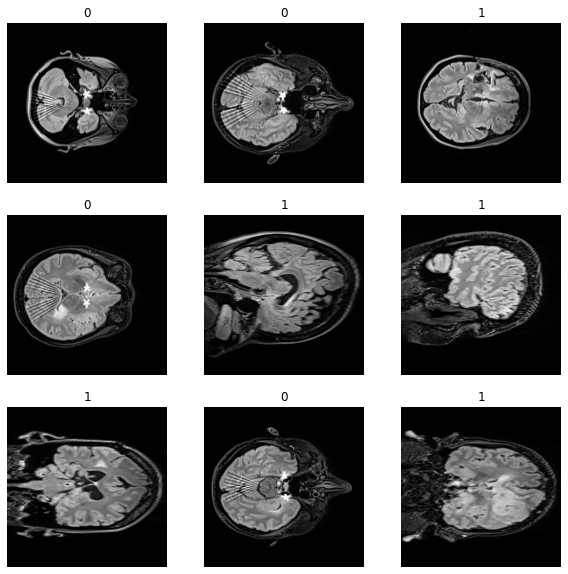

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

## Data augmentation

In [10]:
# data_augmentation = keras.Sequential(
#   [
#     tf.keras.layers.experimental.preprocessing.RandomFlip(
#         "horizontal_and_vertical", input_shape=(256, 256, 1)),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#   ]
# )

In [11]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 1)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)


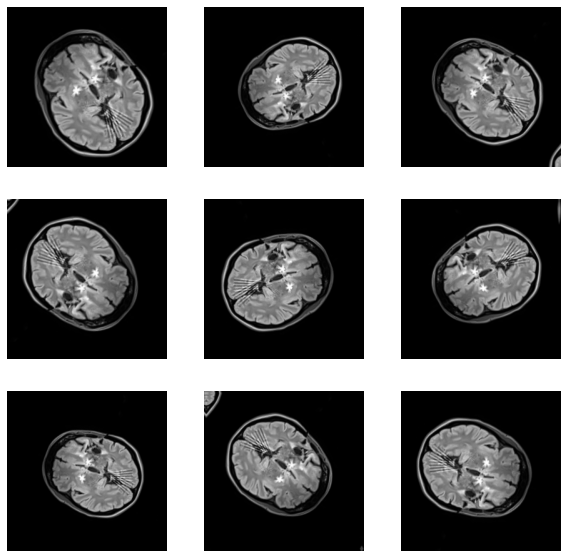

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in training_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

## Build the convolutional neural network
### Here is where the convolution, pooling, and flattening layers will be applied
### `Conv2D` layer. It’s defined with the following parameters:
1) 32 output filters,  
2) 3 by 3 feature detector   
3) the `relu` activation function so as to achieve non-linearity 

### `MaxPooling2D` layer defined with the following parameters:
1) `pool_size` of (2, 2) that defines the size of the pooling window  

### That is followed by the `Flatten` layer whose results are passed to the `Dense` layer. The final layer has 1 units because the dataset has 2 classes. Since it’s a binary problem, the sigmoid activation function is applied.

### Reduce overfitting with Dropout. In this process, a specified percentage of connections are dropped during the training process

    `same` padding to result in even padding for the input  

2) 2 strides that define the number of steps taken by the pooling window 

In [15]:
model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
#     Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
#    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

##  Visualize a deep learning model 

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 1)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)       

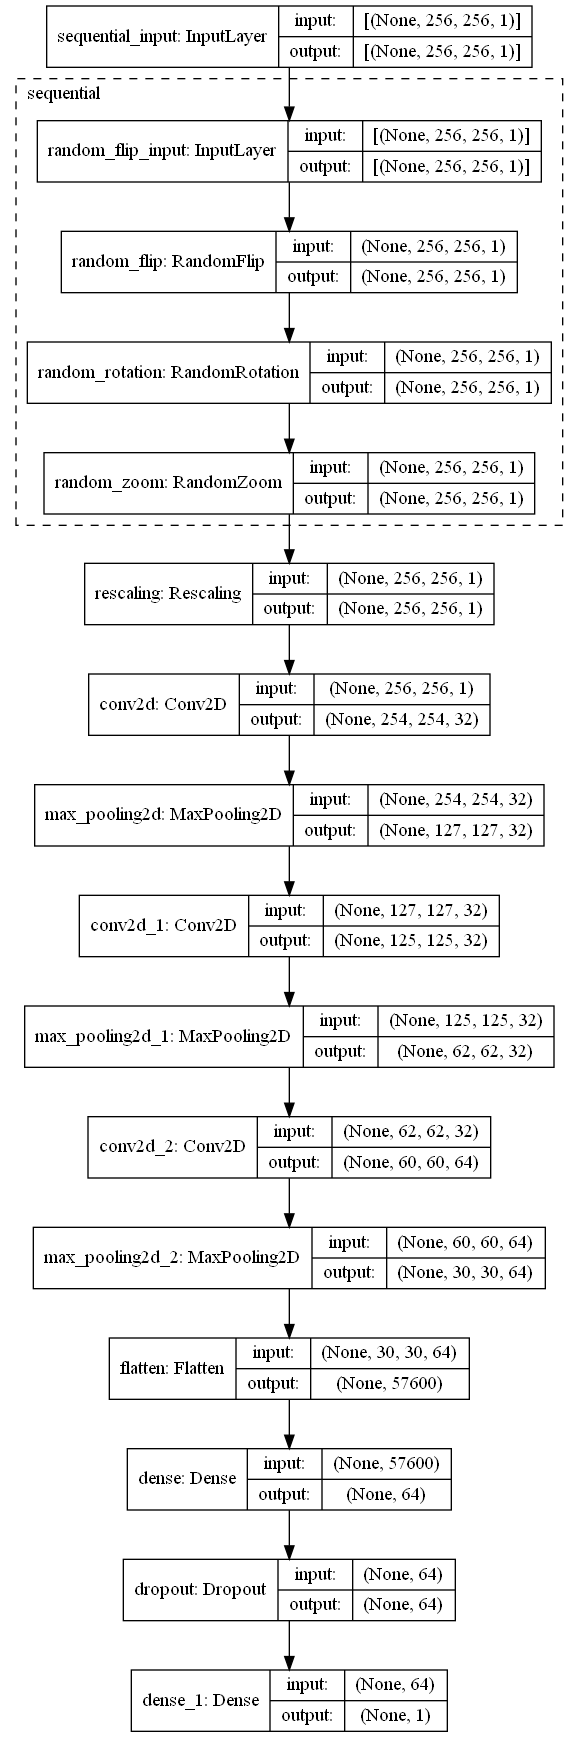

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file=model_dir+ "/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Monitoring the validation loss and save the best model

In [18]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/checkpoint',
    save_weights_only=False,
    monitor='val_loss', 
    mode='min', # mam loss wiec min
    save_best_only=True)

In [19]:
callbacks = [
             EarlyStopping(patience=5),
             model_checkpoint_callback,
]

## Compiling the model


In [20]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [21]:
history = model.fit(
    training_set, validation_data=validation_set,
    epochs=200, callbacks=callbacks)

Epoch 1/200


C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


43/43 [==============================] - 7s 55ms/step - loss: 0.6236 - binary_accuracy: 0.6451 - val_loss: 0.4609 - val_binary_accuracy: 0.8411
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_5\checkpoint\assets
Epoch 2/200
43/43 [==============================] - 2s 44ms/step - loss: 0.4057 - binary_accuracy: 0.8104 - val_loss: 0.2544 - val_binary_accuracy: 0.8874
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_5\checkpoint\assets
Epoch 3/200
43/43 [==============================] - 2s 42ms/step - loss: 0.2656 - binary_accuracy: 0.8898 - val_loss: 0.0894 - val_binary_accuracy: 0.9801
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_5\checkpoint\assets
Epoch 4/200
43/43 [==============================] - 2s 44ms/step - loss: 0.1644 - binary_accuracy: 0.9302 - val_loss: 0.0577 - val_binary_accuracy: 0.9801
INFO:tensorflow:Assets writt

## Monitoring the model’s performance


In [22]:
metrics_df = pd.DataFrame(history.history)

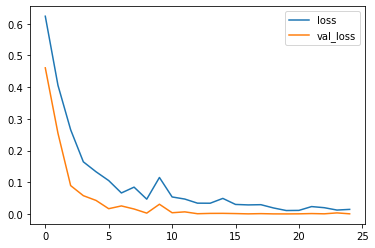

In [23]:
metrics_df[["loss","val_loss"]].plot();

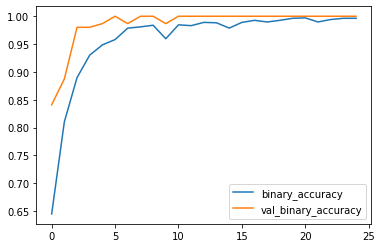

In [24]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

## Checking the performance of the model on the validation set.

In [25]:
loss, accuracy = model.evaluate(validation_set)

5/5 [==============================] - 0s 46ms/step - loss: 4.0809e-04 - binary_accuracy: 1.0000


In [26]:
print('Accuracy on test dataset:', accuracy)

Accuracy on test dataset: 1.0


## Checking the model on the test set.

In [159]:
tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5

for _ in range(300):
    for images, labels in test_set.take(1):
        class_info = int(labels[0])
        
        test_image_orginal = np.expand_dims(images[0].numpy().astype("uint8"), axis=0)
        prediction = model.predict(test_image_orginal)[0][0]

#         print(class_info, prediction)
#         plt.imshow(images[0].numpy().astype("uint8"), cmap='gray')
#         plt.show()


        if prediction >= threshold:
            if class_info == 1:
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if class_info == 0:
                tn = tn + 1
            else:
                fn = fn + 1

print("True positive: {}\nTrue negative: {}\nFalse Positive: {}\nFalse negative: {}".format(tp, tn, fp, fn))

True positive: 141
True negative: 159
False Positive: 0
False negative: 0


In [162]:
tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5

for _ in range(300):
    for images, labels in test_set.take(1):
        class_info = int(labels[0])

#         print(class_info, prediction)
#         plt.imshow(images[0].numpy().astype("uint8"), cmap='gray')
#         plt.show()

        for __ in range(5):
                augmented_images = data_augmentation(images)
                augmented_image = np.expand_dims(augmented_images[0].numpy().astype("uint8"), axis=0)
                prediction = model.predict(augmented_images)[0][0]
                
#                 plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
#                 plt.show()

                if prediction >= threshold:
                    if class_info == 1:
                        tp = tp + 1
                    else:
                        fp = fp + 1
                else:
                    if class_info == 0:
                        tn = tn + 1
                    else:
                        fn = fn + 1


print("True positive: {}\nTrue negative: {}\nFalse Positive: {}\nFalse negative: {}".format(tp, tn, fp, fn))

True positive: 665
True negative: 835
False Positive: 0
False negative: 0
